In [246]:
import pandas as pd
import os.path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

def format_csv(path : str):
    dataset_input  = pd.read_csv(path)
    domains_unique = dataset_input['domain'].unique()
    output_dict = {'timestamp':list()}
    for domain in domains_unique: output_dict[domain]=list()
    for timestamp in dataset_input['timestamp'].unique():
        x = dataset_input.loc[dataset_input['timestamp'] == timestamp]
        output_dict['timestamp'].append(timestamp)
        for domain in domains_unique: 
            serie = x.loc[x['domain'] == domain]['measure']
            output_dict[domain].append(serie.iloc[0]) if len(serie)>0 else output_dict[domain].append(np.nan)
    output_df = pd.DataFrame(output_dict)
    for key in output_df.keys():
        if key not in ['timestamp', 'phase']: output_df[key] = pd.to_numeric(output_df[key], errors='coerce', downcast="float")
    return output_df

def merge_datasets(input_datasets : dict):
    for name, dataset in input_datasets.items(): dataset['dataset'] = name
    return pd.concat(input_datasets.values())

def degree_choice(x,y, degree):
    polynomial_features= PolynomialFeatures(degree=degree)
    x_poly = polynomial_features.fit_transform(pd.DataFrame(x))

    model = LinearRegression()
    model.fit(x_poly, y)
    y_predict = model.predict(x_poly)

    return root_mean_squared_error(y,y_predict)

def best_degree(x, y):
    degree_list=range(1,15)
    rmse_list=list()
    for degree in degree_list:
        rmse_list.append(degree_choice(x,y,degree))
    best_degree = degree_list[min(range(len(rmse_list)), key=rmse_list.__getitem__)]
    return best_degree

def estimate_from_model(model : tuple, x : int, include_static : bool = True):
    (b, coeff )= model
    res = b if include_static else 0
    for degree in range(len(coeff)):
        res+= coeff[degree]*(x**degree)
    return res

def formula_as_str(intercept, coef):
    formula = str(intercept)
    for i in range(len(coef)):
        formula+= ' + ' + str(coef[i]) + '*(x**' + str(i) + ')'
    return 'f(x) = ' + formula

def get_closest_val(source_df, col, row, val, threshold = 0.001):
    sorted_df = source_df.iloc[(source_df[col]-row[col]).abs().argsort()]
    if (sorted_df['host_percent_vm'].iloc[0] - row[col]) > threshold:
        return np.nan
    return sorted_df.iloc[0][val]

def compute_models(training_dict : dict, exclude_beyond : int = None, verbose : bool = False, display : bool = False):

    model_dict = {}
    for level, dataset in training_dict.items():
        clean_training = dataset.dropna()
        if exclude_beyond is not None: 
            clean_training = clean_training.loc[clean_training['cpu%_package-global'] <= exclude_beyond]
        x = clean_training['cpu%_package-global']
        y = clean_training['package-global-watt']
        degree = best_degree(x, y)
        polynomial_features= PolynomialFeatures(degree=degree)
        x_poly = polynomial_features.fit_transform(pd.DataFrame(x))

        model = LinearRegression()
        reg = model.fit(x_poly, y)
        y_predict = model.predict(x_poly)

        if verbose: print(level, '- best degree', degree, 'formula:', formula_as_str(reg.intercept_, reg.coef_))
        if verbose: print(level, '- r2_score /1', r2_score(y,y_predict))
        if verbose: print(level, '- RMSE', root_mean_squared_error(y,y_predict))
        if verbose: print(level, '- mean absolute error', mean_absolute_error(y, y_predict))

        model_dict[level] = (reg.intercept_, reg.coef_)

    if display:
        for level, model in model_dict.items():
            x = range(20)
            y = [estimate_from_model(model, val) for val in x]
            plt.plot(x, y, label=level)

    return model_dict

In [232]:
folder_target = '/home/pierre/src/cinergy-models/models/241029-nova-ok/nova-12.lyon.grid5000.fr-XXX.csv' # Xeon 2016 (16/32, dual)
folder_target = '/home/pierre/src/cinergy-models/models/241029-grappe-novm/grappe-1.nancy.grid5000.fr-XXX.csv' # Xeon 2020 (40/80, dual)
folder_target = '/home/pierre/src/cinergy-models/models/241030-servan-ok/servan-2.grenoble.grid5000.fr-XXX.csv' # Zen 2 (48/96, dual)
folder_target = '/home/pierre/src/cinergy-models/models/241030-chuc-ok/chuc-6.lille.grid5000.fr-XXX.csv' # Zen 3 (32/64, single)

folder_target = '/home/pierre/src/cinergy-models/models/241029-nova-ok/nova-12.lyon.grid5000.fr-XXX.csv' # Xeon 2016 (16/32, dual)

training_dict = {}
training_dict['25'] = format_csv(folder_target.replace('XXX', 'training-25'))
training_dict['50'] = format_csv(folder_target.replace('XXX', 'training-50'))
training_dict['100'] = format_csv(folder_target.replace('XXX', 'training-100'))
dataset_gt = format_csv(folder_target.replace('XXX', 'groundtruth') )
dataset_cl = format_csv(folder_target.replace('XXX', 'cloudlike'))

In [80]:
dataset_gt = format_csv('/home/pierre/src/cinergy-models/models/241028-grappe/grappe-4.nancy.grid5000.fr-groundtruth.csv')
dataset_cl = format_csv('/home/pierre/src/cinergy-models/models/241028-grappe/grappe-4.nancy.grid5000.fr-cloudlike.csv')

In [255]:
model_dict = compute_models(training_dict=training_dict, exclude_beyond=20, verbose=False, display=False)

# Evaluation - Single

In [237]:
def estimate(model_dict : dict, row, core_host : int, keys : list = ['CPU0', 'CPU1', 'CPU2', 'CPU3']):
    return estimate_from_model(model_dict['50'], row['vm']/core_host, include_static=True)

In [234]:
def estimate(model_dict : dict, row, core_host : int, keys : list = ['CPU0', 'CPU1', 'CPU2', 'CPU3']):
    levels = [int(x) for x in model_dict.keys()]
    levels.sort()
    estimation = 0
    include_static = True
    for key in keys:
        for level in levels:
            if level > row[key]: continue
            estimation += estimate_from_model(model_dict[str(level)], row[key]/core_host, include_static=include_static)
            include_static = False
    return estimation

r2_score /1 0.8611501381756517
root mean squared error 3.6599368945753277
mean absolut error 3.1854745823404063


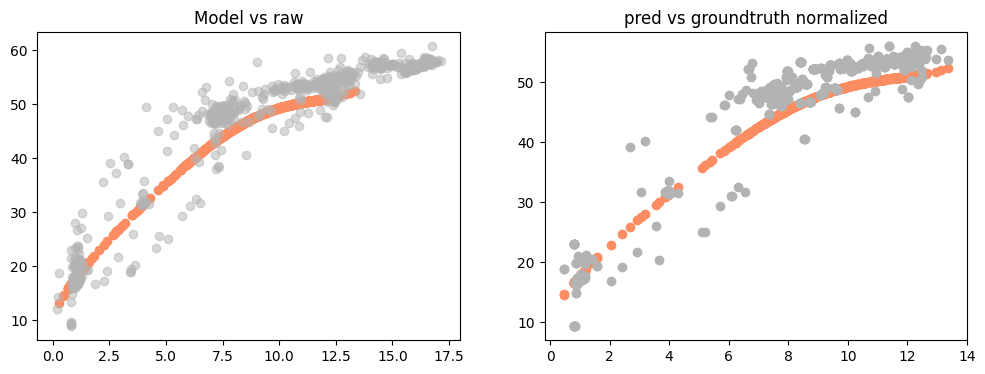

In [254]:
# Groundtruth
core_host_ref = {'nova':32, 'grappe': 80, 'servan':96, 'chuc':64}
core_host = core_host_ref['nova']
groundtruth = dataset_gt.dropna()
groundtruth = groundtruth.assign(host_percent_vm = groundtruth.vm / core_host)

# Prediction on cloud-like dataset
cloudlike = dataset_cl.dropna()
cloudlike = cloudlike.assign(host_percent_vm = cloudlike.vm / core_host)
cloudlike['prediction']= cloudlike.apply(lambda row : estimate(model_dict, row, core_host), axis=1)

colors = sns.color_palette("Set2", 8)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))
ax1.scatter(cloudlike['host_percent_vm'], cloudlike['prediction'], color=colors[1], label='prediction')
ax1.scatter(groundtruth['host_percent_vm'], groundtruth['package-global-watt'], color=colors[-1], label='groundtruth', alpha=0.5)
ax1.title.set_text('Model vs raw')

# Evaluation

evaluation_df = cloudlike
core_host = core_host_ref['nova']
evaluation_df.assign(host_percent_vm = evaluation_df.vm / core_host)
evaluation_df['groundtruth'] = evaluation_df.apply(lambda row : get_closest_val(groundtruth, 'host_percent_vm', row, 'package-global-watt'), axis=1)
evaluation_df['prediction'] = evaluation_df.apply(lambda row : estimate(model_dict, row, core_host), axis=1)
evaluation_df.dropna(inplace=True)
y = evaluation_df['groundtruth']
y_predict = evaluation_df['prediction']

print('r2_score /1', r2_score(y,y_predict))
print('root mean squared error', root_mean_squared_error(y,y_predict))
print('mean absolut error', mean_absolute_error(y, y_predict))

ax2.scatter(evaluation_df['host_percent_vm'], evaluation_df['prediction'], color=colors[1])
ax2.scatter(evaluation_df['host_percent_vm'], evaluation_df['groundtruth'], color=colors[-1])
ax2.title.set_text('pred vs groundtruth normalized')


# Evaluation multiple

In [107]:
folder_source = {}
folder_source['nova'] = '/home/pierre/src/cinergy-models/models/241029-nova-ok/nova-12.lyon.grid5000.fr-XXX.csv' # Xeon 2016 (16/32, dual)
#folder_source['grappe'] = '/home/pierre/src/cinergy-models/models/241029-grappe-novm/grappe-1.nancy.grid5000.fr-XXX.csv' # Xeon 2020 (40/80, dual)
folder_source['servan'] = '/home/pierre/src/cinergy-models/models/241030-servan-ok/servan-2.grenoble.grid5000.fr-XXX.csv' # Zen 2 (48/96, dual)
folder_source['chuc'] = '/home/pierre/src/cinergy-models/models/241030-chuc-ok/chuc-6.lille.grid5000.fr-XXX.csv' # Zen 3 (32/64, single)

data_source = {}
for name, folder in folder_source.items():
    training_dict = {}
    training_dict['25'] = format_csv(folder.replace('XXX', 'training-25'))
    training_dict['50'] = format_csv(folder.replace('XXX', 'training-50'))
    training_dict['100'] = format_csv(folder.replace('XXX', 'training-100'))
    dataset_gt = format_csv(folder.replace('XXX', 'groundtruth') )
    dataset_cl = format_csv(folder.replace('XXX', 'cloudlike'))
    data_source[name] = (training_dict, dataset_gt, dataset_cl)
    print(name, 'loaded')

nova loaded
servan loaded
chuc loaded


In [163]:
def estimate(model_dict : dict, row, core_host : int, keys : list = ['CPU0', 'CPU1', 'CPU2', 'CPU3']):
    return estimate_from_model(model_dict['50'], row['vm']/core_host, include_static=True)

In [1]:
fig, axes = plt.subplots(1,len(data_source), figsize=(12, 4))
index = 0

core_host_ref = {'nova':32, 'grappe': 80, 'servan':96, 'chuc':64}
for name, data in data_source.items():
    (training_dict, dataset_gt, dataset_cl) = data
    vm_size = 4
    exclude_beyond = (vm_size * 100) / core_host * 1.5
    model_dict = compute_models(training_dict=training_dict, exclude_beyond=exclude_beyond, verbose=False, display=False)

    # Groundtruth
    core_host = core_host_ref[name]
    groundtruth = dataset_gt.dropna()
    groundtruth = groundtruth.assign(host_percent_vm = groundtruth.vm / core_host)
    
    # Prediction on cloudlike dataset
    cloudlike = dataset_cl.dropna()
    cloudlike = cloudlike.assign(host_percent_vm = cloudlike.vm / core_host)
    cloudlike['prediction']= cloudlike.apply(lambda row : estimate(model_dict, row, core_host), axis=1)

    colors = sns.color_palette("Set2", 8)
    axes[index].scatter(cloudlike['host_percent_vm'], cloudlike['prediction'], color=colors[1], label='prediction')
    axes[index].scatter(groundtruth['host_percent_vm'], groundtruth['package-global-watt'], color=colors[-1], label='groundtruth', alpha=0.5)
    axes[index].title.set_text(name)
    index+=1

plt.show()


NameError: name 'plt' is not defined

In [2]:
core_host_ref = {'nova':32, 'grappe': 80, 'servan':96, 'chuc':64}
fig, axes = plt.subplots(1,len(data_source), figsize=(12, 4))
index = 0

for name, data in data_source.items():
    (training_dict, dataset_gt, dataset_cl) = data
    core_host = core_host_ref[name]

    vm_size = 4
    exclude_beyond = (vm_size * 100) / core_host * 1.5
    model_dict = compute_models(training_dict=training_dict, exclude_beyond=exclude_beyond, verbose=False, display=False)

    # Groundtruth
    groundtruth = dataset_gt.dropna()
    groundtruth = groundtruth.assign(host_percent_vm = groundtruth.vm / core_host)
    
    # Prediction on cloudlike dataset
    cloudlike = dataset_cl.dropna()
    cloudlike = cloudlike.assign(host_percent_vm = cloudlike.vm / core_host)

    evaluation_df = cloudlike
    evaluation_df.assign(host_percent_vm = evaluation_df.vm / core_host)
    evaluation_df['groundtruth'] = evaluation_df.apply(lambda row : get_closest_val(groundtruth, 'host_percent_vm', row, 'package-global-watt'), axis=1)
    evaluation_df['prediction'] = evaluation_df.apply(lambda row : estimate(model_dict, row, core_host), axis=1)
    evaluation_df.dropna(inplace=True)
    y = evaluation_df['groundtruth']
    y_predict = evaluation_df['prediction']

    print(name, 'r2_score /1', r2_score(y,y_predict))
    print(name, 'root mean squared error', root_mean_squared_error(y,y_predict))
    print(name, 'mean absolut error', mean_absolute_error(y, y_predict))
    print('')

    axes[index].scatter(evaluation_df['host_percent_vm'], evaluation_df['prediction'], color=colors[1])
    axes[index].scatter(evaluation_df['host_percent_vm'], evaluation_df['groundtruth'], color=colors[-1])
    axes[index].title.set_text(name)
    index+=1


NameError: name 'plt' is not defined